In [2]:
from google.colab import drive
drive.mount('/content/drive')

from urllib.request import urlopen
from PIL import Image
import torch
from transformers import AutoFeatureExtractor, ResNetForImageClassification, ResNetModel
import os
from PIL import Image
from torch.utils.data import TensorDataset, DataLoader
import time
import numpy as np
device = 'cuda'
from transformers import ResNetModel
import torch

def train(net, train_dataloader, criterion, optimizer, scheduler=None, epochs=100, device=device, checkpoint_epochs=2, timeout=45):
    start = time.time()
    print(f'Training for {epochs} epochs on {device}')

    for epoch in range(1,epochs+1):
        print(f"Epoch {epoch}/{epochs}")

        net.train()  # put network in train mode for Dropout and Batch Normalization
        train_loss = torch.tensor(0., device=device)  # loss and accuracy tensors are on the GPU to avoid data transfers
        train_accuracy = torch.tensor(0., device=device)
        for X, y in train_dataloader:
            X = X.to(device)
            y = y.type(torch.LongTensor).to(device)
            preds = net(X)
            loss = criterion(preds, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                train_loss += loss * train_dataloader.batch_size
                train_accuracy += (torch.argmax(preds, dim=1) == y).sum()

        if scheduler is not None:
            scheduler.step()

        print(f'Training loss: {train_loss/len(train_dataloader.dataset):.2f}')
        print(f'Training accuracy: {100*train_accuracy/len(train_dataloader.dataset):.2f}')


        if epoch%checkpoint_epochs==0:
            torch.save({
                'epoch': epoch,
                'state_dict': net.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, './checkpoint.pth.tar')

        print()
        if((time.time() - start) >= timeout):
          break

    end = time.time()
    print(f'Total training time: {end-start:.1f} seconds')
    return net

# model definition
class Classifier_model(torch.nn.Module):
    # define model elements
    def __init__(self):
        super(Classifier_model, self).__init__()
        self.device = device
        self.image_processor = AutoFeatureExtractor.from_pretrained("microsoft/resnet-18",device=self.device)
        self.pre_trained_model = ResNetModel.from_pretrained("microsoft/resnet-18")
        resnet18_output_size=25088
        self.fc = torch.nn.Linear(resnet18_output_size, 10)
        self.activation = torch.nn.ReLU()

    # forward propagate input
    def forward(self, X):
        X = self.image_processor(X, return_tensors="pt").to(self.device)
        # print(X.pixel_value.is_cuda)
        X = self.pre_trained_model(**X).last_hidden_state.flatten(start_dim=1)
        X = self.activation(X)
        X = self.fc(X)

        return X.softmax(dim=1)

    def features_extractor(self, X):
        X = self.image_processor(X, return_tensors="pt").to(self.device)
        # print(X.pixel_value.is_cuda)
        X = self.pre_trained_model(**X).last_hidden_state.flatten(start_dim=1)

        return X.softmax(dim=1)

# model definition
class Classifier_model_2(torch.nn.Module):
    # define model elements
    def __init__(self,f_model):
        super(Classifier_model_2, self).__init__()
        self.device = device
        resnet18_output_size=25088
        self.f_model = f_model
        self.fc = torch.nn.Linear(resnet18_output_size, 2)
        self.activation = torch.nn.ReLU()

    # forward propagate input
    def forward(self, X):
        #X = self.image_processor(X, return_tensors="pt").to(self.device)
        # print(X.pixel_value.is_cuda)
        X = self.f_model.features_extractor(X)
        X = self.activation(X)
        X = self.fc(X)

        return X.softmax(dim=1)


# Chemin du répertoire racine
import random
root_dir = '/content/drive/MyDrive/ColabNotebooks/mel'

# Dictionnaire pour stocker les images par sous-dossier
image_dict = {}

# Parcourir tous les sous-dossiers
for root, dirs, files in os.walk(root_dir):
    for file in files:
        # Construire le chemin complet du fichier
        file_path = os.path.join(root, file)

        # Vérifier si le fichier est une image en fonction de l'extension (par exemple, .png)
        if file_path.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
            # Ouvrir l'image avec Pillow
            image = Image.open(file_path)

            # Convertir l'image en format JPG (si elle n'est pas déjà en JPG)
            if image.format != "JPEG":
                image = image.convert("RGB")

            # Obtenez le nom du sous-dossier parent
            parent_dir = os.path.basename(os.path.dirname(file_path))

            # Vérifiez si le sous-dossier existe dans le dictionnaire, sinon créez-le
            if parent_dir not in image_dict:
                image_dict[parent_dir] = []

            # Ajouter l'image à la liste du sous-dossier correspondant
            image = image.resize((336,219))
            image_dict[parent_dir].append(np.array(image))

classical_list_MG = image_dict['classic']
non_classical_list_MG = image_dict['non_classic']

percent_classical_MG = int(0.2*len(classical_list_MG))
percent_non_classical_MG = int(0.2*len(non_classical_list_MG))


evaluation_list_dic = []
for sample in classical_list_MG[:percent_classical_MG]:
    buffer = []
    buffer.append(sample)
    buffer.append(0)
    evaluation_list_dic.append(buffer)

for sample in non_classical_list_MG[:percent_non_classical_MG]:
    buffer = []
    buffer.append(sample)
    buffer.append(1)
    evaluation_list_dic.append(buffer)

random.shuffle(evaluation_list_dic)
evaluation_list = []
for sample in evaluation_list_dic:
    evaluation_list.append(sample[0])

activeL_classical_list = classical_list_MG[percent_classical_MG:]
activeL_non_classical_list = non_classical_list_MG[percent_non_classical_MG:]


Indices des échantillons sélectionnés : [49 38 20]
kmeans_label :  [0 2 0 0 0 1 0 2 2 0 2 2 2 0 1 2 0 2 0 1 2 0 2 1 2 1 0 1 1 0 2 1 1 1 2 1 1
 2 1 0 0 0 1 0 0 2 1 0 1 0 0 2 1 0 0 2 1 0 1 1 2 1 2 2 0 0 0 0 0 0 2 1 1 0
 2 0 2 1 0 1 2 0 0 0 0 2 2 2 0 1 2 0 0 2 1 0 1 2 1 0]


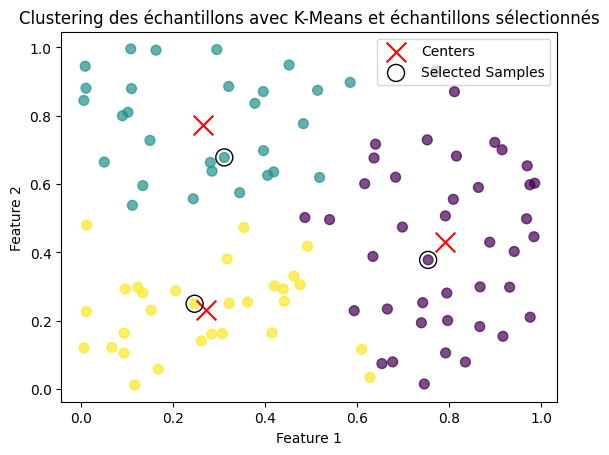

In [3]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# Charger votre dataset dans la variable X
# Remplacez cette ligne par le chargement réel de votre dataset
X = np.random.rand(100, 2)  # Exemple avec des données aléatoires

# Spécifier le nombre de clusters que vous souhaitez
n_clusters = 3

# Effectuer le clustering avec l'algorithme K-Means
kmeans = KMeans(n_clusters=n_clusters, n_init="auto")
kmeans.fit(X)

# Obtenir les centres des clusters
cluster_centers = kmeans.cluster_centers_

# Calculer les distances euclidiennes de chaque échantillon par rapport au centre de son cluster
distances = cdist(X, cluster_centers, 'euclidean')

# Sélectionner l'échantillon le plus proche de chaque centre de cluster
selected_samples = np.argmin(distances, axis=0)

# Afficher les indices des échantillons sélectionnés
print("Indices des échantillons sélectionnés :", selected_samples)
print("kmeans_label : ", kmeans.labels_)

# Tracer les échantillons avec des couleurs différentes pour chaque cluster
scatter = plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='viridis', s=50, alpha=0.7)

# Tracer les centres des clusters en rouge
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=200, label='Centers')

# Tracer les échantillons sélectionnés avec un cercle autour
selected_samples_x = X[selected_samples, 0]
selected_samples_y = X[selected_samples, 1]
plt.scatter(selected_samples_x, selected_samples_y, facecolors='none', edgecolors='black', s=150, label='Selected Samples')

# Ajouter des légendes et des titres
plt.title('Clustering des échantillons avec K-Means et échantillons sélectionnés')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# Afficher le graphe
plt.show()


len dataset :  800
800
3
Indices des échantillons sélectionnés : [304 249 678]


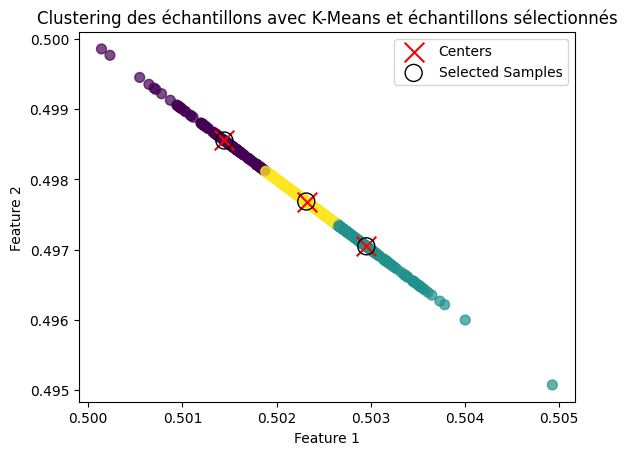

In [7]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import torch

# Charger votre dataset dans la variable X
# Remplacez cette ligne par le chargement réel de votre dataset
# X = np.random.rand(100, 2)  # Exemple avec des données aléatoires
X = np.concatenate((activeL_classical_list, activeL_non_classical_list))
print("len dataset : ",len(X))
model = torch.load("/content/drive/MyDrive/ColabNotebooks/model_2_Clem_trainings_longEgale_Colab.pt")
model.eval()
with torch.no_grad():
  preds = model(X)

preds_numpy = preds.numpy(force=True)
# Spécifier le nombre de clusters que vous souhaitez
n_clusters = 3

# Effectuer le clustering avec l'algorithme K-Means
kmeans = KMeans(n_clusters=n_clusters, n_init="auto")
kmeans.fit(preds_numpy)
print(len(preds_numpy))

# Obtenir les centres des clusters
cluster_centers = kmeans.cluster_centers_

# Calculer les distances euclidiennes de chaque échantillon par rapport au centre de son cluster
distances = cdist(preds_numpy, cluster_centers, 'euclidean')

# Sélectionner l'échantillon le plus proche de chaque centre de cluster
selected_samples = np.argmin(distances, axis=0)
selected_samples_data = X[selected_samples]
print(len(selected_samples_data))

# Afficher les indices des échantillons sélectionnés
print("Indices des échantillons sélectionnés :", selected_samples)
# print("kmeans_label : ", kmeans.labels_)

# Tracer les échantillons avec des couleurs différentes pour chaque cluster
scatter = plt.scatter(preds_numpy[:, 0], preds_numpy[:, 1], c=kmeans.labels_, cmap='viridis', s=50, alpha=0.7)

# Tracer les centres des clusters en rouge
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=200, label='Centers')

# Tracer les échantillons sélectionnés avec un cercle autour
selected_samples_x = preds_numpy[selected_samples, 0]
selected_samples_y = preds_numpy[selected_samples, 1]
plt.scatter(selected_samples_x, selected_samples_y, facecolors='none', edgecolors='black', s=150, label='Selected Samples')

# Ajouter des légendes et des titres
plt.title('Clustering des échantillons avec K-Means et échantillons sélectionnés')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# Afficher le graphe
plt.show()


In [5]:
# Now, we need to recreate two tensors knowing if each samples contained
# inside the dataset is classical or not.
new_active_classical = []
new_active_non_classical = []

for item in selected_samples_data:
    if any(np.array_equal(item, x) for x in activeL_classical_list):
        new_active_classical.append(item)
    else:
        new_active_non_classical.append(item)

print(len(new_active_classical))
print(len(new_active_non_classical))

if (len(new_active_classical) == 0):
  tensor_x = torch.Tensor(new_active_non_classical).to(device)
  tensor_y = torch.Tensor(np.full(len(new_active_non_classical),  1)).to(device)

else:
  tensor_x = torch.Tensor(np.concatenate((new_active_classical, new_active_non_classical), axis = 0)).to(device)
  tensor_y = torch.Tensor(np.concatenate((np.full(len(new_active_classical), 0),
                                      np.full(len(new_active_non_classical),  1)), axis=0)).to(device)

print(tensor_x, tensor_y)

my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader = DataLoader(my_dataset,batch_size=10, shuffle=True)

1
2
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
tensor([[[[255., 255., 255.],
          [255., 255., 255.],
          [255., 255., 255.],
          ...,
          [255., 255., 255.],
          [255., 255., 255.],
          [255., 255., 255.]],

         [[255., 255., 255.],
          [255., 255., 255.],
          [255., 255., 255.],
          ...,
          [255., 255., 255.],
          [255., 255., 255.],
    

In [8]:
lr, weight_decay, epochs,timeout = 1e-5, 5e-4, 1000, 30
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr, weight_decay=weight_decay)
net2 = train(model, my_dataloader, loss, optimizer, None, epochs, device, timeout=timeout)


Training for 1000 epochs on cuda
Epoch 1/1000
Training loss: 2.31
Training accuracy: 33.33

Epoch 2/1000
Training loss: 2.31
Training accuracy: 33.33

Epoch 3/1000
Training loss: 2.31
Training accuracy: 33.33

Epoch 4/1000
Training loss: 2.31
Training accuracy: 33.33

Epoch 5/1000
Training loss: 2.31
Training accuracy: 33.33

Epoch 6/1000
Training loss: 2.31
Training accuracy: 33.33

Epoch 7/1000
Training loss: 2.31
Training accuracy: 33.33

Epoch 8/1000
Training loss: 2.31
Training accuracy: 33.33

Epoch 9/1000
Training loss: 2.31
Training accuracy: 33.33

Epoch 10/1000
Training loss: 2.31
Training accuracy: 33.33

Epoch 11/1000
Training loss: 2.31
Training accuracy: 33.33

Epoch 12/1000
Training loss: 2.31
Training accuracy: 33.33

Epoch 13/1000
Training loss: 2.31
Training accuracy: 33.33

Epoch 14/1000
Training loss: 2.30
Training accuracy: 33.33

Epoch 15/1000
Training loss: 2.30
Training accuracy: 66.67

Epoch 16/1000
Training loss: 2.30
Training accuracy: 66.67

Epoch 17/1000
Tr